In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from yellowbrick import features, target, classifier

from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

from IPython.core.display import display, HTML

display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
# radviz was too slow and not legible 

In [3]:
df = pd.read_parquet("preprocessed_all.parquet")

In [4]:
non_feature_cols = ["ProtocolName", "target"]

/Users/ajaypethani/anaconda3/envs/cauca/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


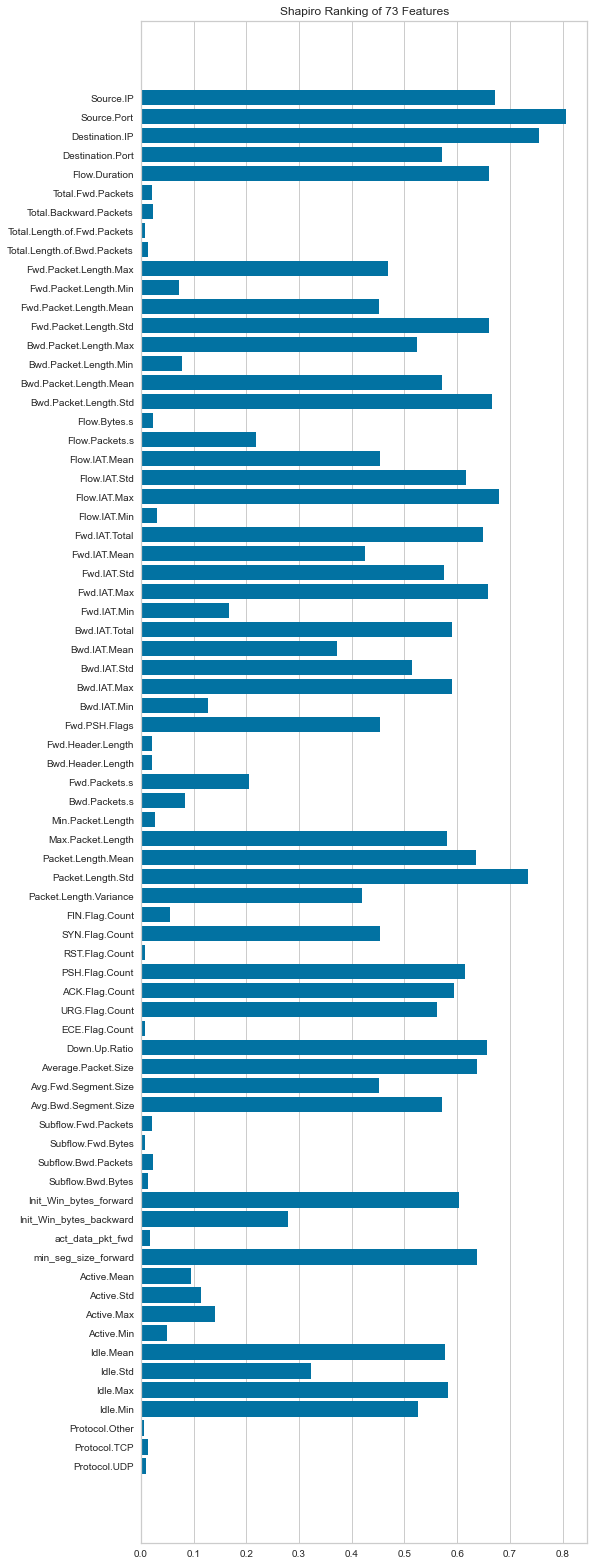

/Users/ajaypethani/anaconda3/envs/cauca/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


Rank1D(algorithm=None,
       ax=<AxesSubplot:title={'center':'Shapiro Ranking of 73 Features'}>,
       orient=None, show_feature_names=None)

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(8, 28))
features.rank1d(df.drop(columns=non_feature_cols), df["target"])

In [6]:
# ParallelCoordinates slow and not legible

In [7]:
df = pd.read_parquet("preprocessed_all.parquet")
classes = df["ProtocolName"].value_counts().head(5).index.to_list()
df = df[df["ProtocolName"].isin(classes)]
labelencoder = LabelEncoder()
df["target"] = labelencoder.fit_transform(df["ProtocolName"])
df.reset_index(inplace=True, drop=True)

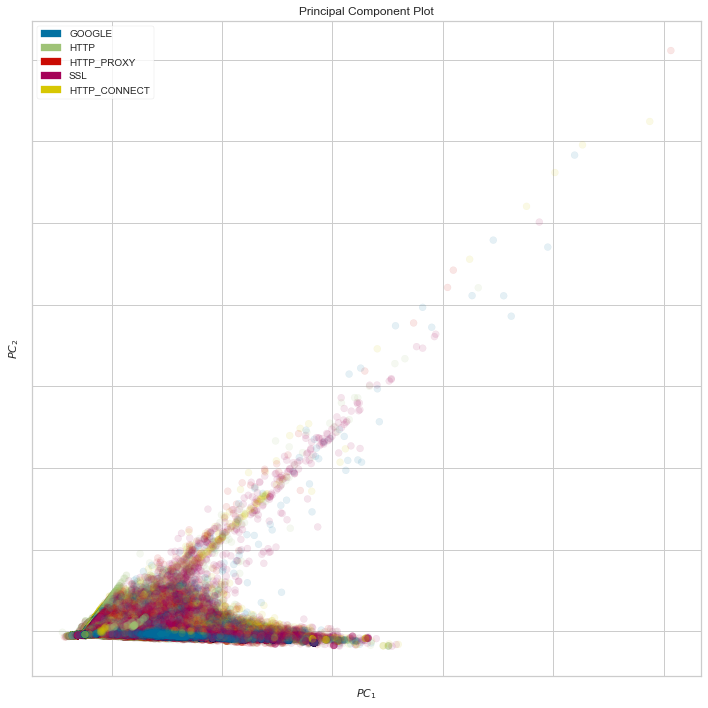

<AxesSubplot:title={'center':'Principal Component Plot'}, xlabel='$PC_1$', ylabel='$PC_2$'>

In [8]:
visualizer = features.PCA(scale=True, classes=classes, size=(720, 720), alpha=0.1)
visualizer.fit_transform(df.drop(columns=non_feature_cols), df["target"])
visualizer.show()

/Users/ajaypethani/anaconda3/envs/cauca/lib/python3.8/site-packages/yellowbrick/features/pca.py:448: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.fig.tight_layout()
/Users/ajaypethani/anaconda3/envs/cauca/lib/python3.8/site-packages/yellowbrick/features/pca.py:448: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()


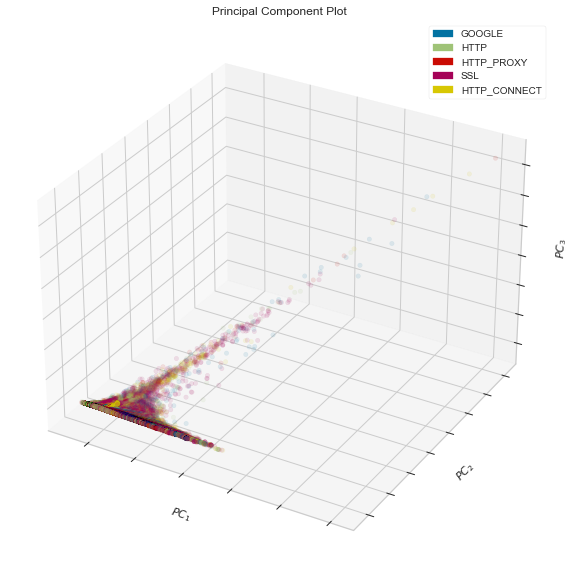

<Axes3DSubplot:title={'center':'Principal Component Plot'}, xlabel='$PC_1$', ylabel='$PC_2$'>

In [9]:
visualizer = features.PCA(
    scale=True,
    classes=classes,
    size=(720, 720),
    alpha=0.1,
    projection=3
)
visualizer.fit_transform(df.drop(columns=non_feature_cols), df["target"])
visualizer.show()

In [10]:
# biplot not legible when number of features is high

In [11]:
# mutual_info-classification too slow and memory hungry, and cannot retain result and chart

## Using a simple MLP to try out more methods from Yellowbrick

In [12]:
df = pd.read_parquet("preprocessed_all.parquet")
with open("./metadata_preprocessing/protocol_name_encoding.json", "r") as f:
    encoder = json.load(f)

In [13]:
(X_train, X_test,
 y_train, y_test) = train_test_split(df.drop(columns=non_feature_cols),
                                     df["target"],
                                     test_size=0.25,
                                     stratify=df["target"],
                                     random_state=42)
scaler = StandardScaler()
rescaled_X_train = scaler.fit_transform(X_train)
rescaled_X_test = scaler.transform(X_test)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2675394, 73), (891799, 73), (2675394,), (891799,))

In [14]:
clf = MLPClassifier(
    hidden_layer_sizes=(128,),
    activation="logistic",
    alpha=0.01,
    tol=0.01,
    batch_size=100000,
    learning_rate="adaptive",
    learning_rate_init=0.05,
    max_iter=30,
    n_iter_no_change=5,
    verbose=True,
    random_state=42
)
clf.fit(rescaled_X_train, y_train)
y_pred = clf.predict(rescaled_X_test)

Iteration 1, loss = 1.95530839
Iteration 2, loss = 1.47315916
Iteration 3, loss = 1.33642111
Iteration 4, loss = 1.26306163
Iteration 5, loss = 1.21493172
Iteration 6, loss = 1.18108718
Iteration 7, loss = 1.15402780
Iteration 8, loss = 1.13289757
Iteration 9, loss = 1.11516342
Iteration 10, loss = 1.10222251
Iteration 11, loss = 1.09032908
Iteration 12, loss = 1.07739400
Iteration 13, loss = 1.06740493
Iteration 14, loss = 1.05955386
Iteration 15, loss = 1.05160670
Iteration 16, loss = 1.04616307
Iteration 17, loss = 1.03818829
Iteration 18, loss = 1.03593456
Training loss did not improve more than tol=0.010000 for 5 consecutive epochs. Stopping.


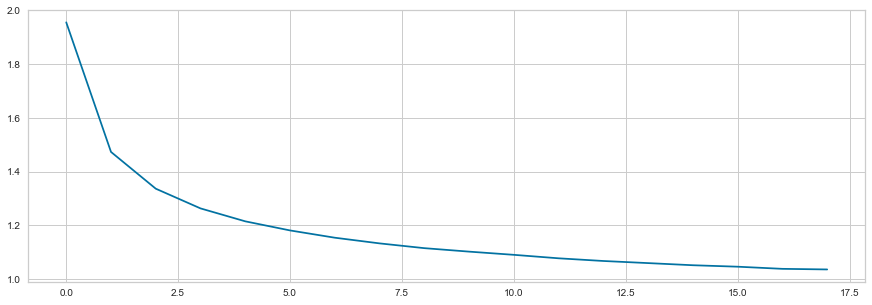

In [15]:
plt.figure(figsize=(15, 5))
plt.plot(clf.loss_curve_)

In [16]:
100*((y_test == y_pred).sum())/len(y_pred)

66.92864647751342

/Users/ajaypethani/anaconda3/envs/cauca/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
/Users/ajaypethani/anaconda3/envs/cauca/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


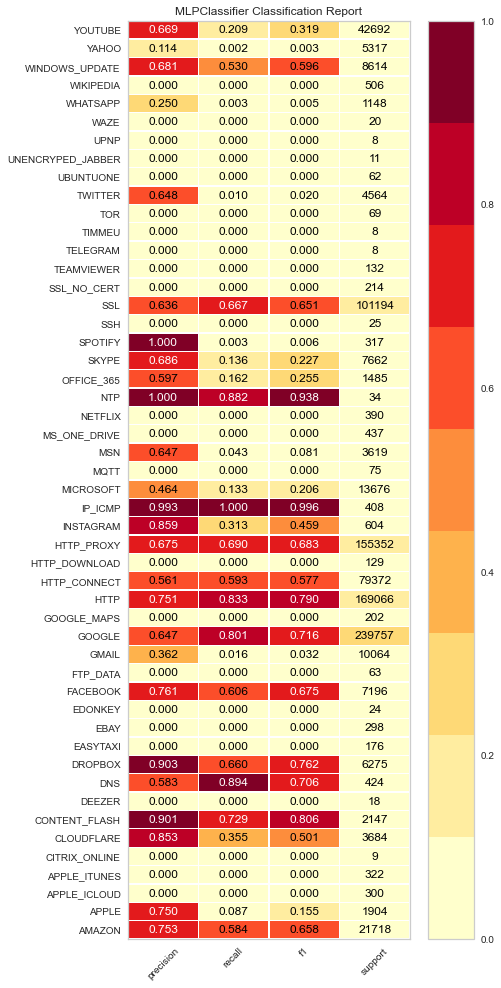

<AxesSubplot:title={'center':'MLPClassifier Classification Report'}>

In [17]:
visualizer = classifier.ClassificationReport(clf, classes=list(encoder),
                                             support=True, is_fitted=True,
                                             size=(500, 1000))

visualizer.fit(rescaled_X_train, y_train)
visualizer.score(rescaled_X_test, y_test)
visualizer.show()

/Users/ajaypethani/anaconda3/envs/cauca/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


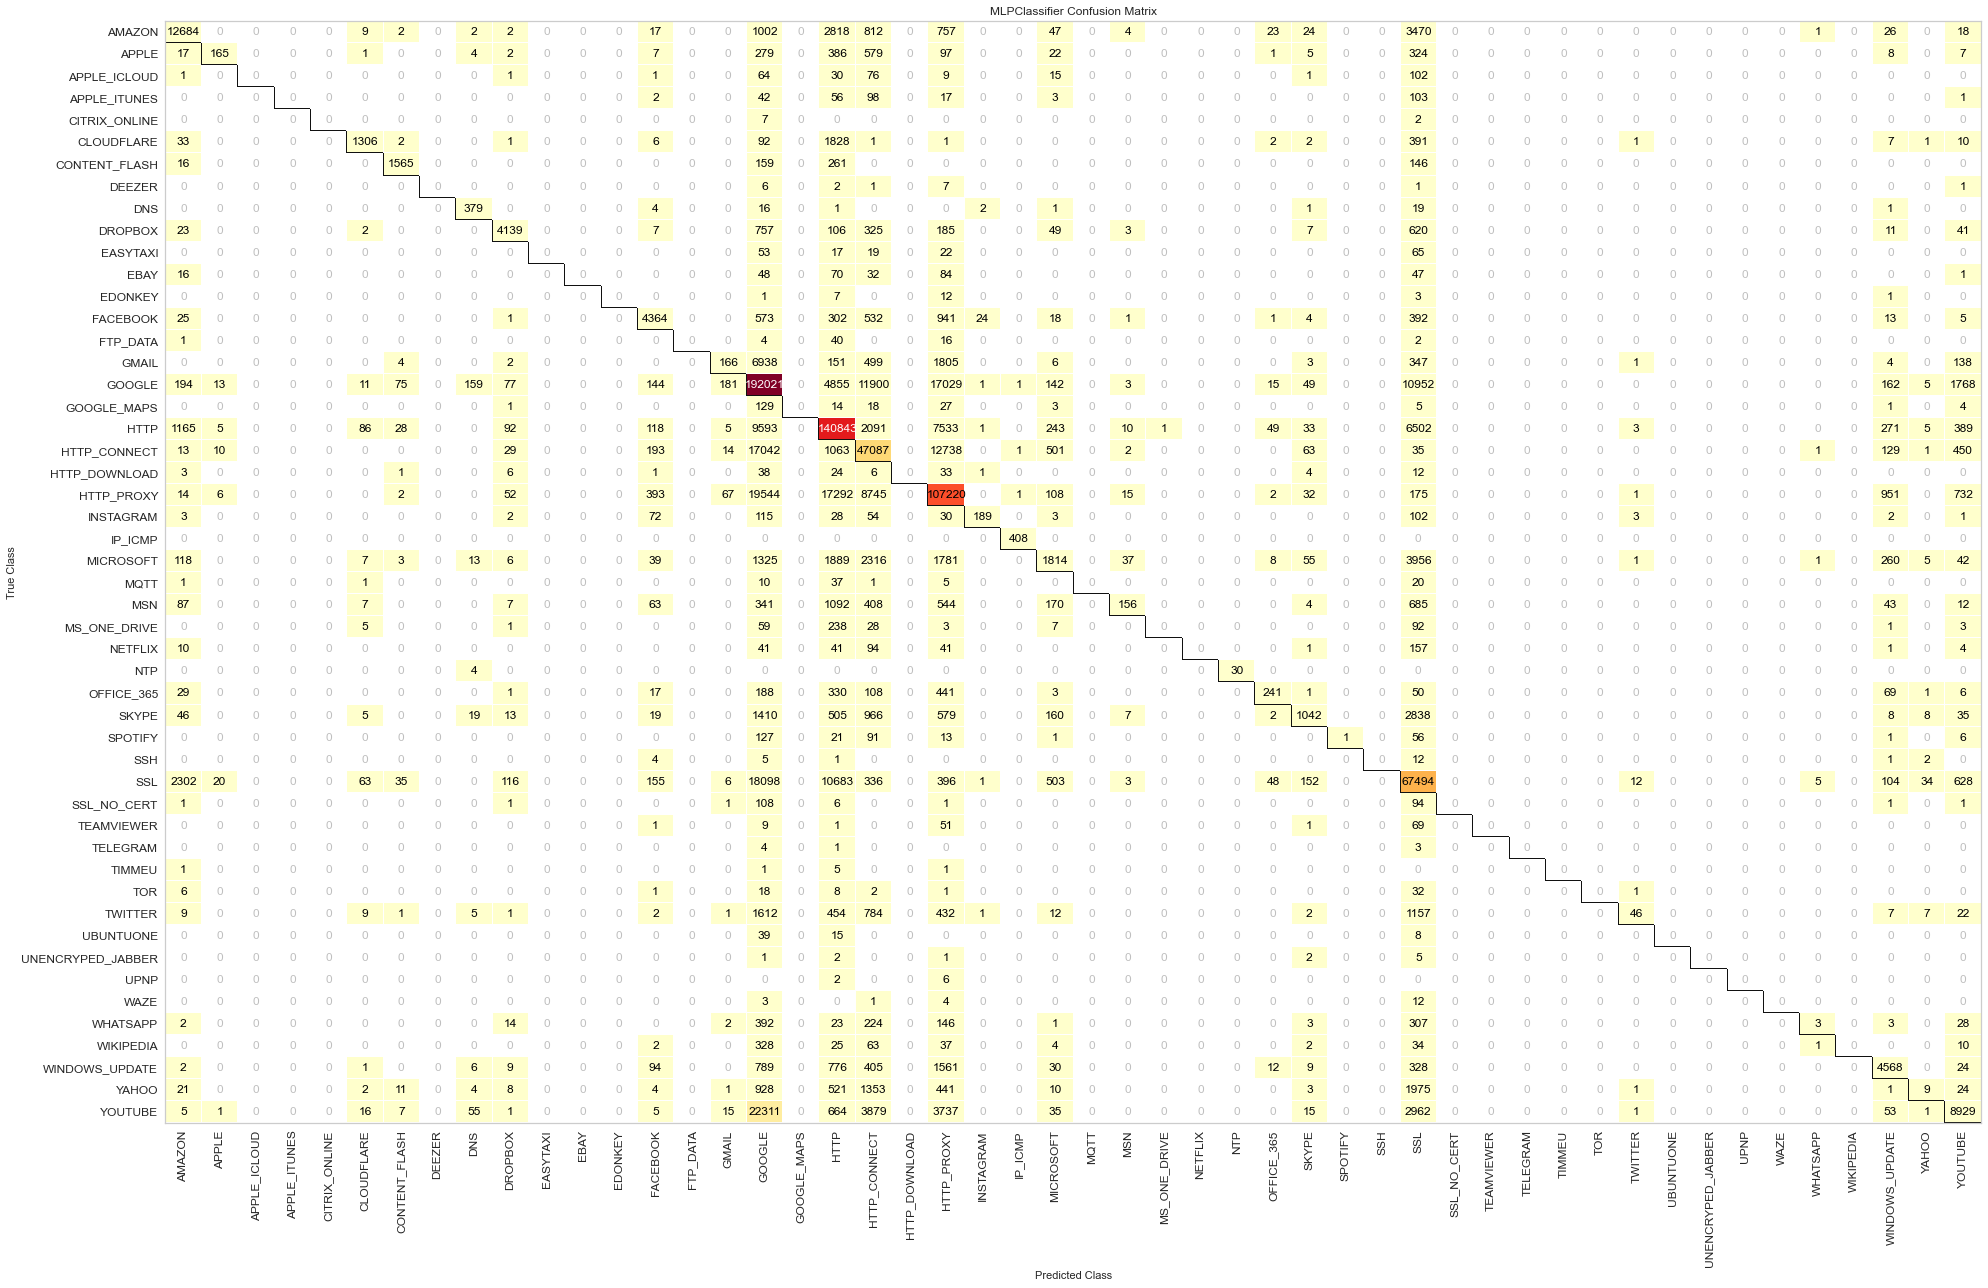

<AxesSubplot:title={'center':'MLPClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [18]:
cm = classifier.ConfusionMatrix(clf, classes=list(encoder),
                                is_fitted=True, size=(2000, 1300))
cm.fit(rescaled_X_train, y_train)
cm.score(rescaled_X_test, y_test)
cm.show()

In [19]:
# visualizer = classifier.ROCAUC(clf, classes=list(encoder), is_fitted=True)
# visualizer.fit(X_train, y_train)
# visualizer.score(X_test, y_test)
# visualizer.show()

/Users/ajaypethani/anaconda3/envs/cauca/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


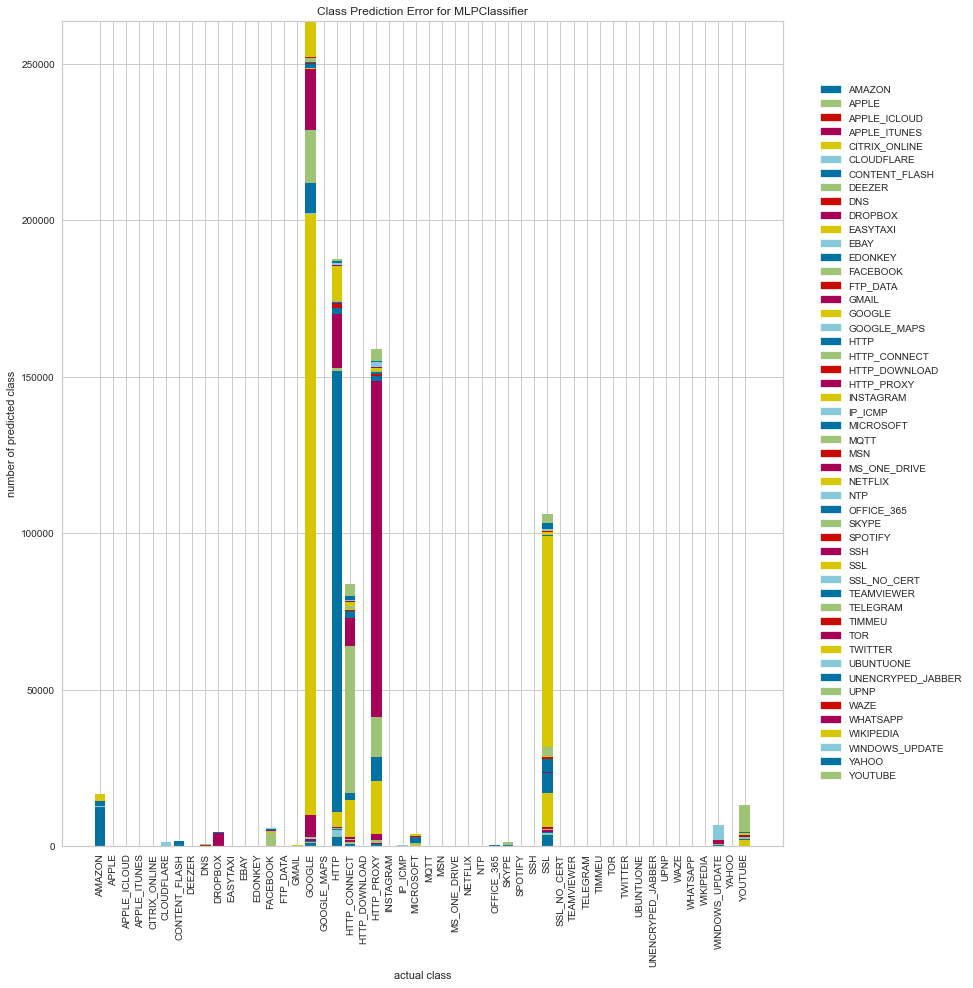

<AxesSubplot:title={'center':'Class Prediction Error for MLPClassifier'}, xlabel='actual class', ylabel='number of predicted class'>

In [20]:
visualizer = classifier.ClassPredictionError(clf, classes=list(encoder),
                                             is_fitted=True, size=(1100, 1000))
visualizer.fit(rescaled_X_train, y_train)
visualizer.score(rescaled_X_test, y_test)
visualizer.show()

In [21]:
100*((y_test == y_pred).sum())/len(y_pred)

66.92864647751342

## Apply PCA before fitting a smaller neural network

In [22]:
scaler = StandardScaler()
rescaled_X_train = scaler.fit_transform(X_train)
pca = PCA(random_state=42)
rescaled_X_train = pd.DataFrame(pca.fit_transform(rescaled_X_train))
rescaled_X_train.columns = [f"PCA{i}" for i in range(1, rescaled_X_train.shape[1] + 1)]

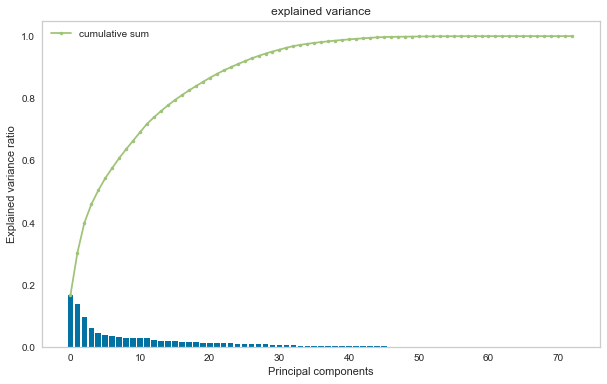

In [23]:
explained_variance = pca.explained_variance_ratio_
plt.figure(figsize=(10, 6))
plt.bar(range(len(explained_variance)), explained_variance, align='center')
plt.plot(range(len(explained_variance)), explained_variance.cumsum(), marker='.', color='g', label='cumulative sum')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.title('explained variance')
plt.legend()
plt.grid()

In [24]:
components_to_keep = np.argmax(explained_variance.cumsum() > 0.975) + 1
components_to_keep

35

In [25]:
rescaled_X_train = rescaled_X_train[rescaled_X_train.columns[:components_to_keep]]
rescaled_X_test = pd.DataFrame(pca.transform(scaler.transform(X_test)))
rescaled_X_test = rescaled_X_test[rescaled_X_test.columns[:components_to_keep]]
rescaled_X_train.shape, rescaled_X_test.shape

((2675394, 35), (891799, 35))

In [26]:
clf = MLPClassifier(
    hidden_layer_sizes=(64,),
    activation="logistic",
    alpha=0.01,
    tol=0.01,
    batch_size=100000,
    learning_rate="adaptive",
    learning_rate_init=0.05,
    max_iter=30,
    n_iter_no_change=5,
    verbose=True,
    random_state=42
)
clf.fit(rescaled_X_train, y_train)
y_pred = clf.predict(rescaled_X_test)

Iteration 1, loss = 1.82585554
Iteration 2, loss = 1.45074759
Iteration 3, loss = 1.35160226
Iteration 4, loss = 1.29855402
Iteration 5, loss = 1.26512580
Iteration 6, loss = 1.24178718
Iteration 7, loss = 1.22362248
Iteration 8, loss = 1.20856346
Iteration 9, loss = 1.19647628
Iteration 10, loss = 1.18622279
Iteration 11, loss = 1.17734428
Iteration 12, loss = 1.16996297
Iteration 13, loss = 1.16311039
Iteration 14, loss = 1.15711057
Iteration 15, loss = 1.15215614
Iteration 16, loss = 1.14759200
Training loss did not improve more than tol=0.010000 for 5 consecutive epochs. Stopping.


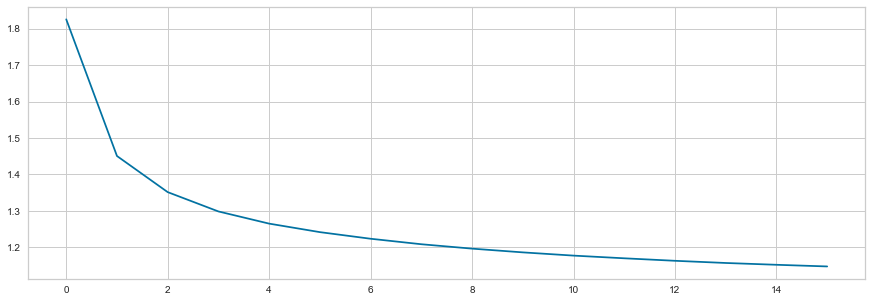

In [27]:
plt.figure(figsize=(15, 5))
plt.plot(clf.loss_curve_)

/Users/ajaypethani/anaconda3/envs/cauca/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
/Users/ajaypethani/anaconda3/envs/cauca/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


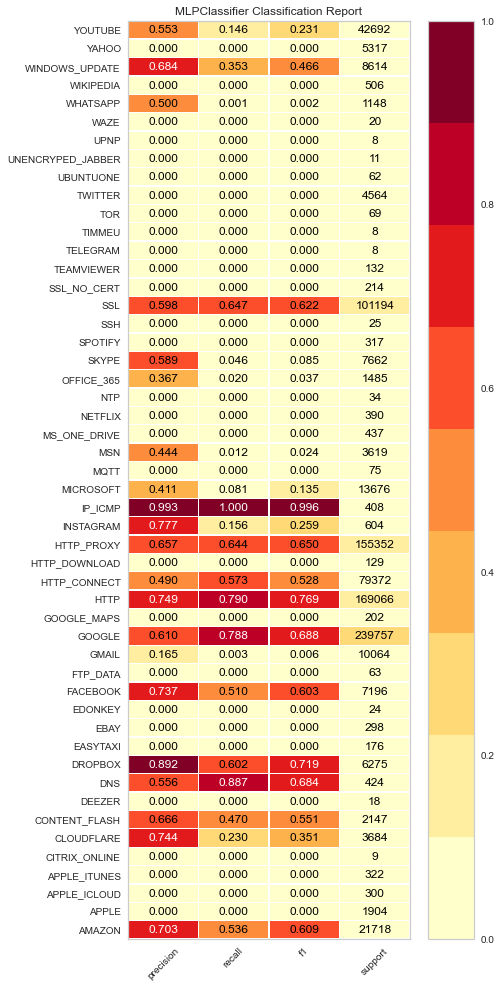

<AxesSubplot:title={'center':'MLPClassifier Classification Report'}>

In [28]:
visualizer = classifier.ClassificationReport(clf, classes=list(encoder),
                                             support=True, is_fitted=True,
                                             size=(500, 1000))

visualizer.fit(rescaled_X_train, y_train)
visualizer.score(rescaled_X_test, y_test)
visualizer.show()      

/Users/ajaypethani/anaconda3/envs/cauca/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


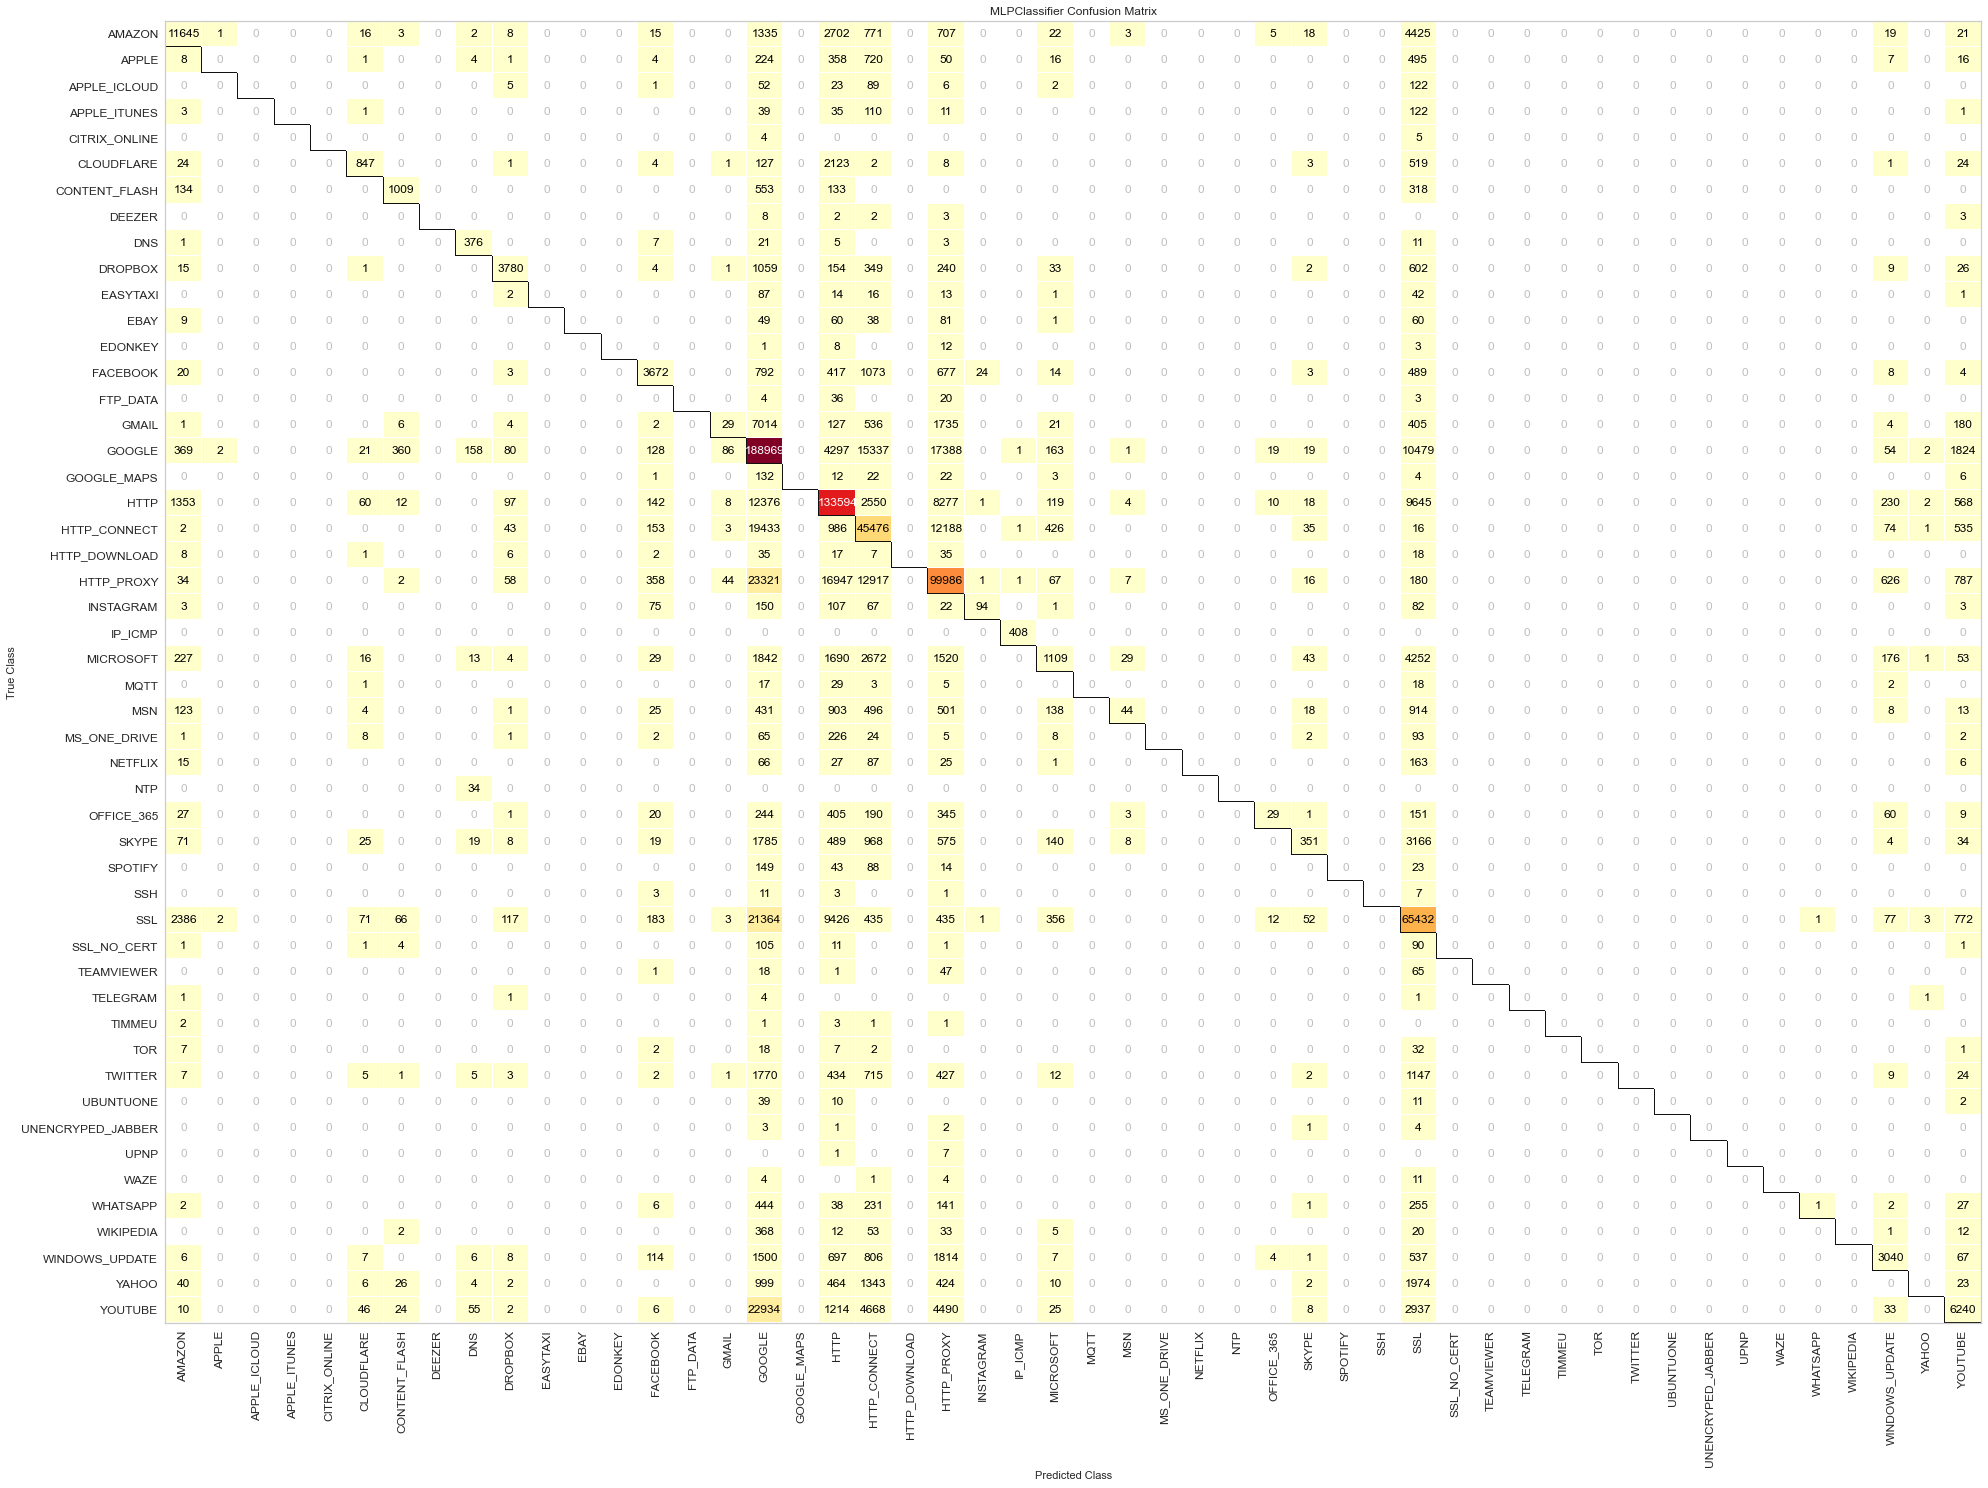

<AxesSubplot:title={'center':'MLPClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [29]:
cm = classifier.ConfusionMatrix(clf, classes=list(encoder),
                                is_fitted=True, size=(2000, 1500))
cm.fit(rescaled_X_train, y_train)
cm.score(rescaled_X_test, y_test)
cm.show()

/Users/ajaypethani/anaconda3/envs/cauca/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


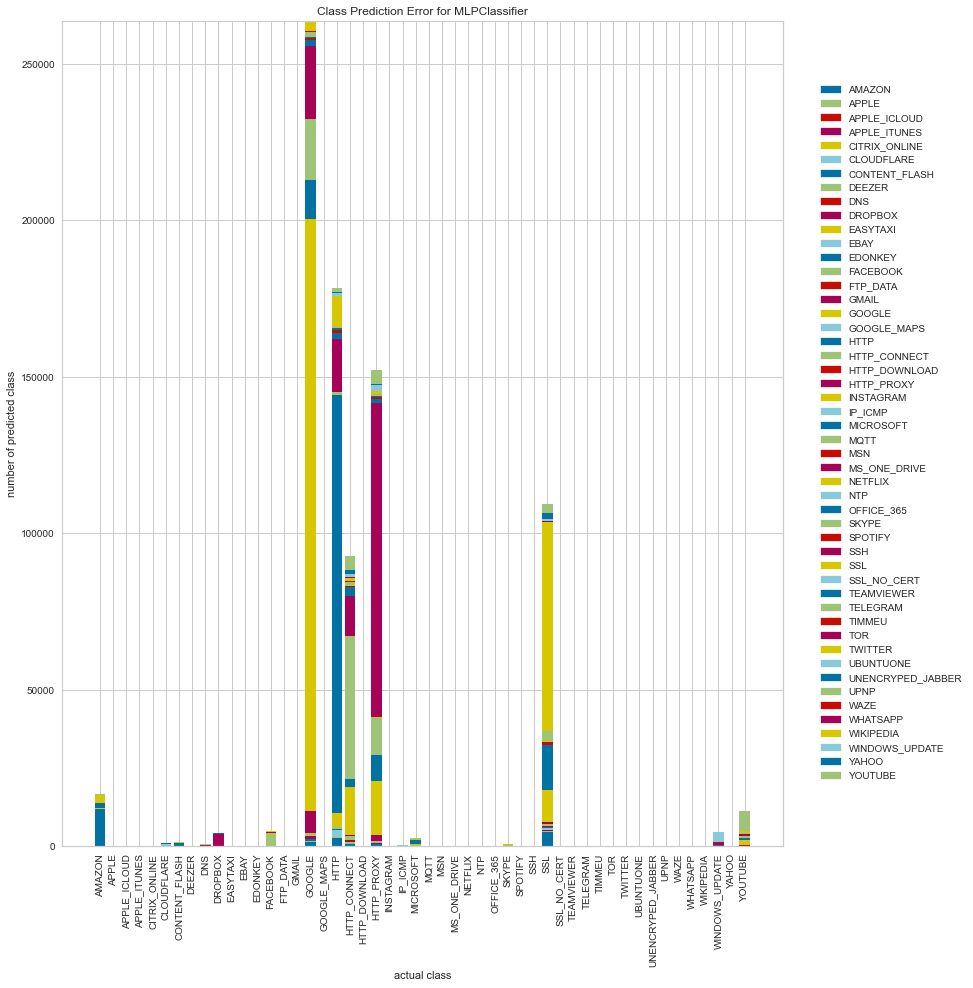

<AxesSubplot:title={'center':'Class Prediction Error for MLPClassifier'}, xlabel='actual class', ylabel='number of predicted class'>

In [30]:
visualizer = classifier.ClassPredictionError(clf, classes=list(encoder),
                                             is_fitted=True, size=(1100, 1000))
visualizer.fit(rescaled_X_train, y_train)
visualizer.score(rescaled_X_test, y_test)
visualizer.show()

In [31]:
100*((y_test == y_pred).sum())/len(y_pred)

63.48190567605481

## Trying just using log transformation

In [32]:
df = pd.read_parquet("preprocessed_all.parquet")
with open("./metadata_preprocessing/protocol_name_encoding.json", "r") as f:
    encoder = json.load(f)
    
for col in df.columns:
    if col in ["ProtocolName", "target"]:
        continue
    else:
        df[col] = np.log(df[col].abs()+1)
        
(X_train, X_test,
 y_train, y_test) = train_test_split(df.drop(columns=non_feature_cols),
                                     df["target"],
                                     test_size=0.25,
                                     stratify=df["target"],
                                     random_state=42)
scaler = StandardScaler()
rescaled_X_train = scaler.fit_transform(X_train)
rescaled_X_test = scaler.transform(X_test)

In [33]:
clf = MLPClassifier(
    hidden_layer_sizes=(128,),
    activation="logistic",
    alpha=0.01,
    tol=0.01,
    batch_size=100000,
    learning_rate="adaptive",
    learning_rate_init=0.05,
    max_iter=30,
    n_iter_no_change=5,
    verbose=True,
    random_state=42
)
clf.fit(rescaled_X_train, y_train)
y_pred = clf.predict(rescaled_X_test)

Iteration 1, loss = 2.03044179
Iteration 2, loss = 1.49766416
Iteration 3, loss = 1.28566712
Iteration 4, loss = 1.17482969
Iteration 5, loss = 1.11305866
Iteration 6, loss = 1.07486631
Iteration 7, loss = 1.04627853
Iteration 8, loss = 1.02564519
Iteration 9, loss = 1.00917926
Iteration 10, loss = 0.99636214
Iteration 11, loss = 0.98915214
Iteration 12, loss = 0.97345786
Iteration 13, loss = 0.96376572
Iteration 14, loss = 0.95725647
Iteration 15, loss = 0.95009257
Iteration 16, loss = 0.94889880
Iteration 17, loss = 0.94227807
Iteration 18, loss = 0.93554233
Training loss did not improve more than tol=0.010000 for 5 consecutive epochs. Stopping.


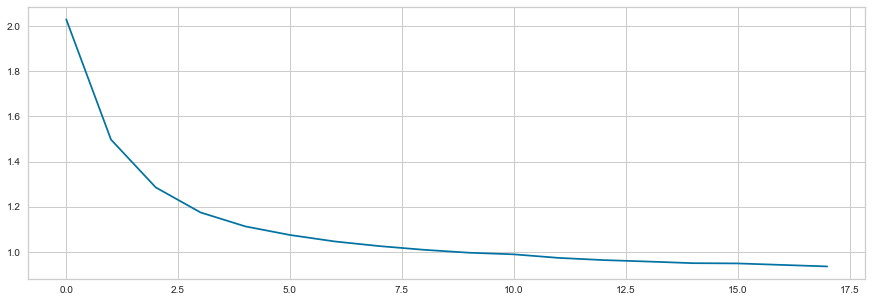

In [34]:
plt.figure(figsize=(15, 5))
plt.plot(clf.loss_curve_)

/Users/ajaypethani/anaconda3/envs/cauca/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
/Users/ajaypethani/anaconda3/envs/cauca/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


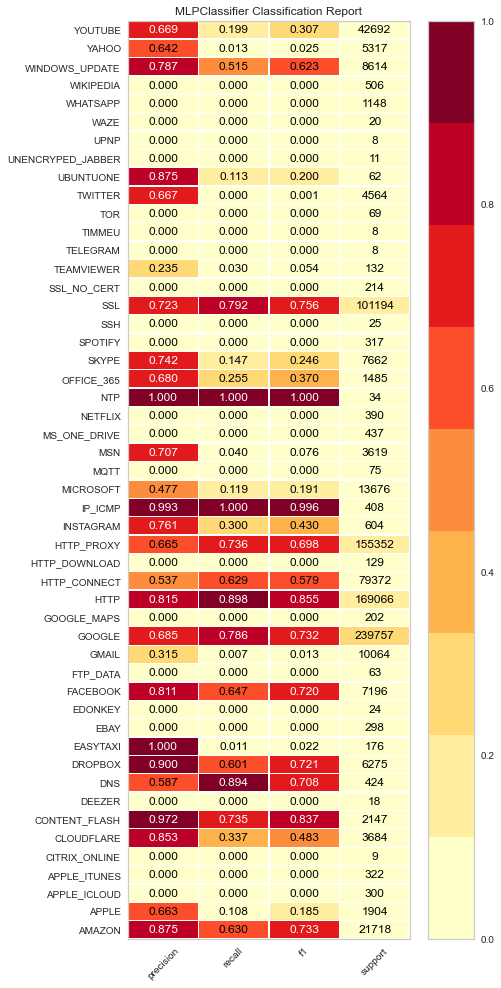

<AxesSubplot:title={'center':'MLPClassifier Classification Report'}>

In [35]:
visualizer = classifier.ClassificationReport(clf, classes=list(encoder),
                                             support=True, is_fitted=True,
                                             size=(500, 1000))

visualizer.fit(rescaled_X_train, y_train)
visualizer.score(rescaled_X_test, y_test)
visualizer.show()

/Users/ajaypethani/anaconda3/envs/cauca/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


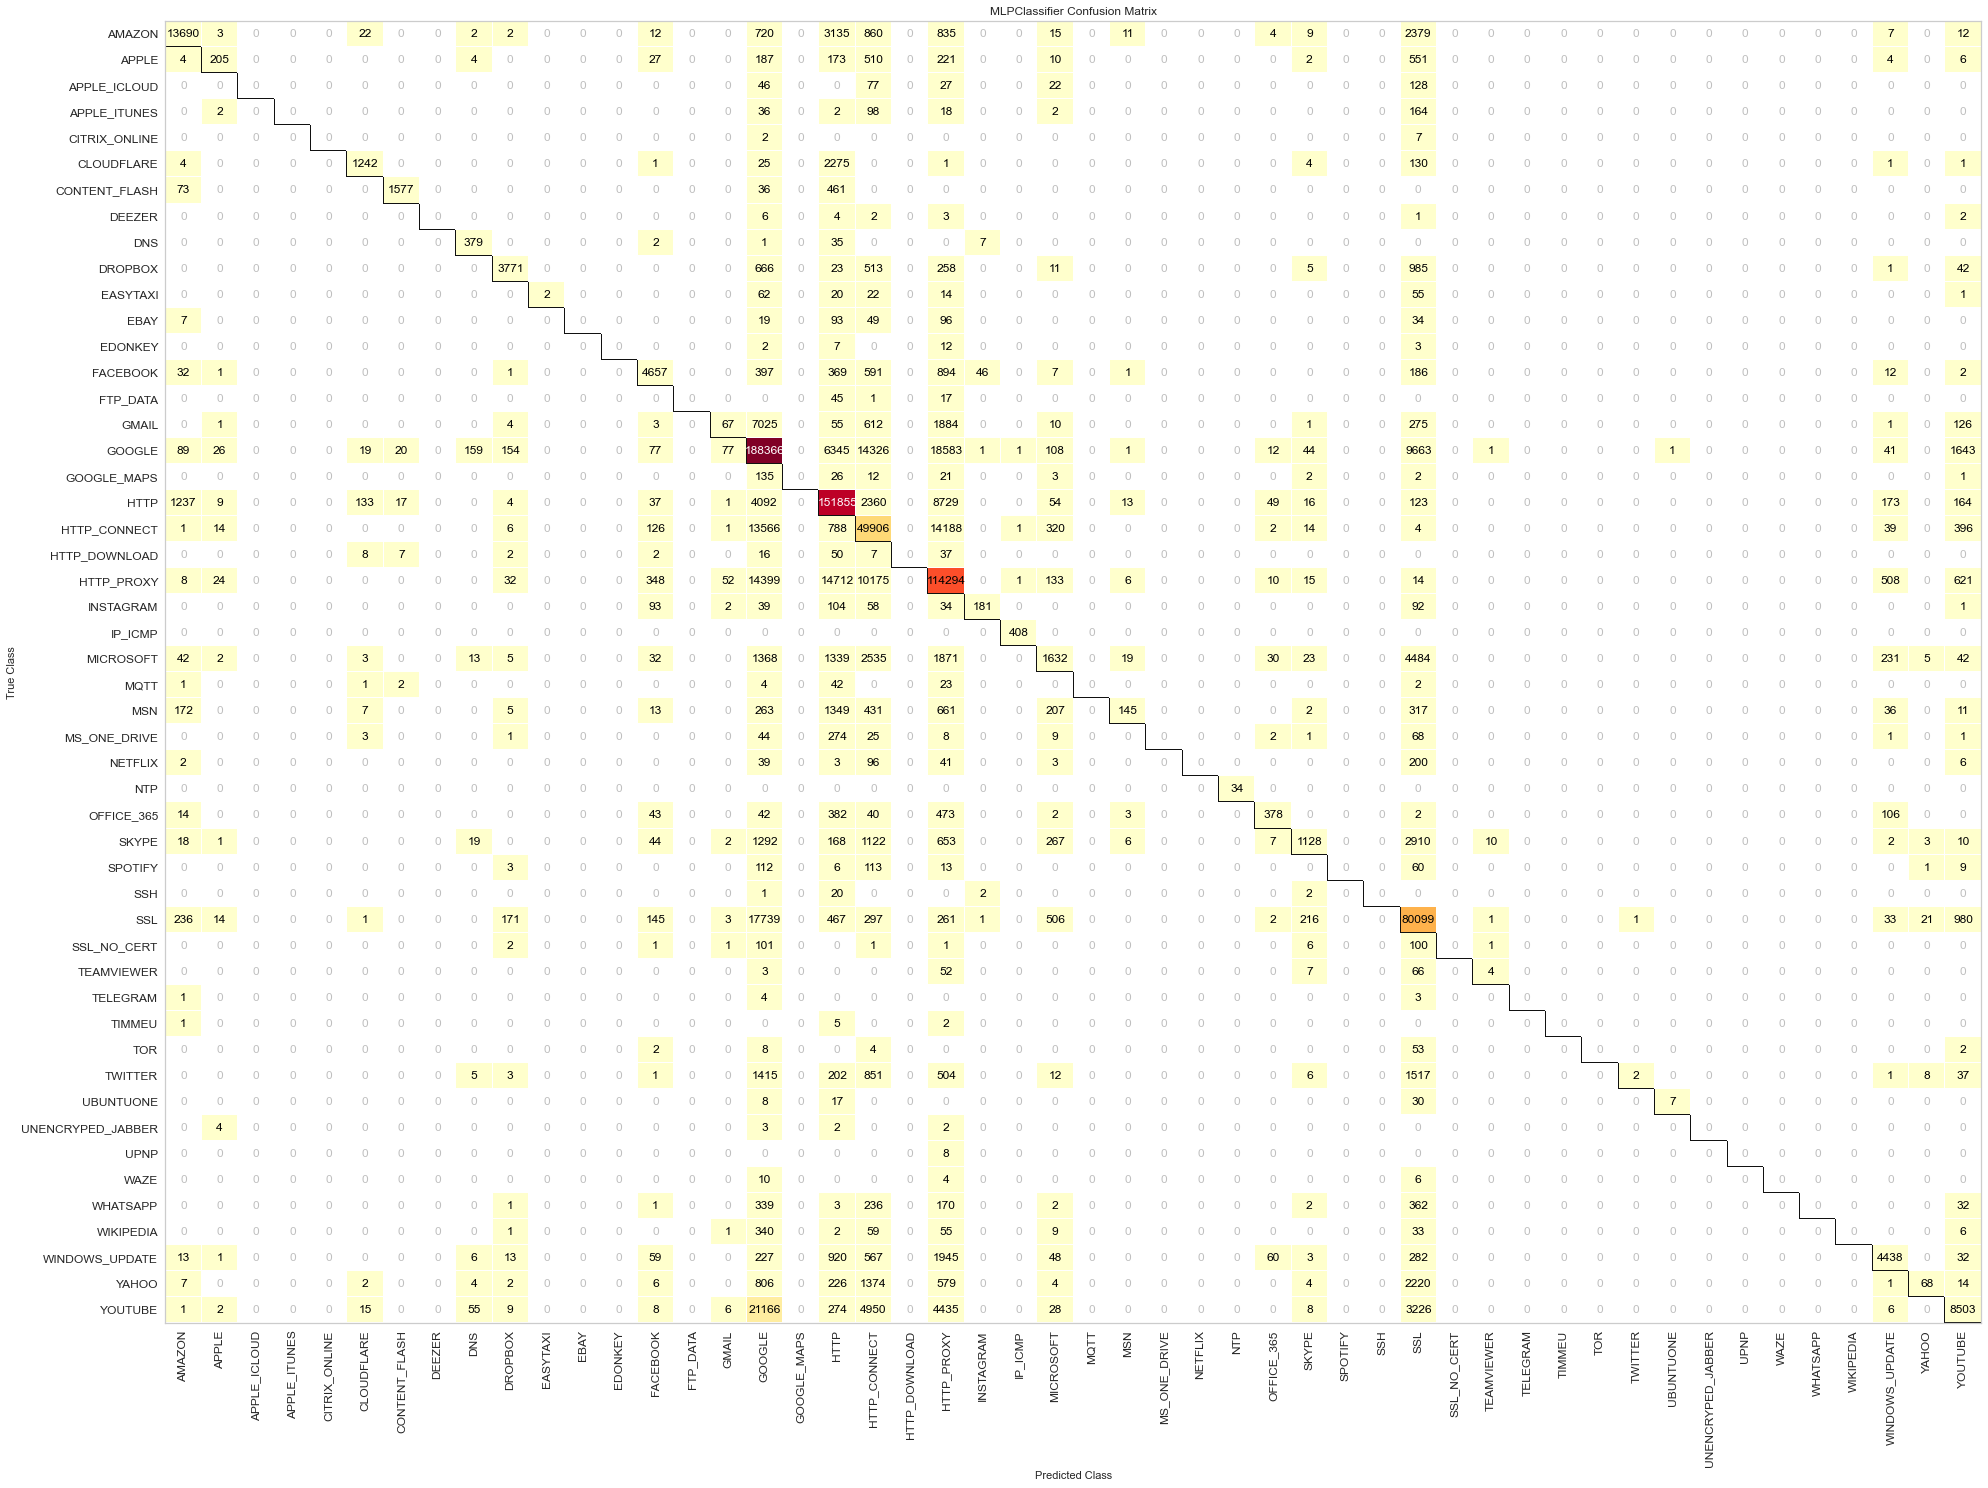

<AxesSubplot:title={'center':'MLPClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [36]:
cm = classifier.ConfusionMatrix(clf, classes=list(encoder),
                                is_fitted=True, size=(2000, 1500))
cm.fit(rescaled_X_train, y_train)
cm.score(rescaled_X_test, y_test)
cm.show() 

/Users/ajaypethani/anaconda3/envs/cauca/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


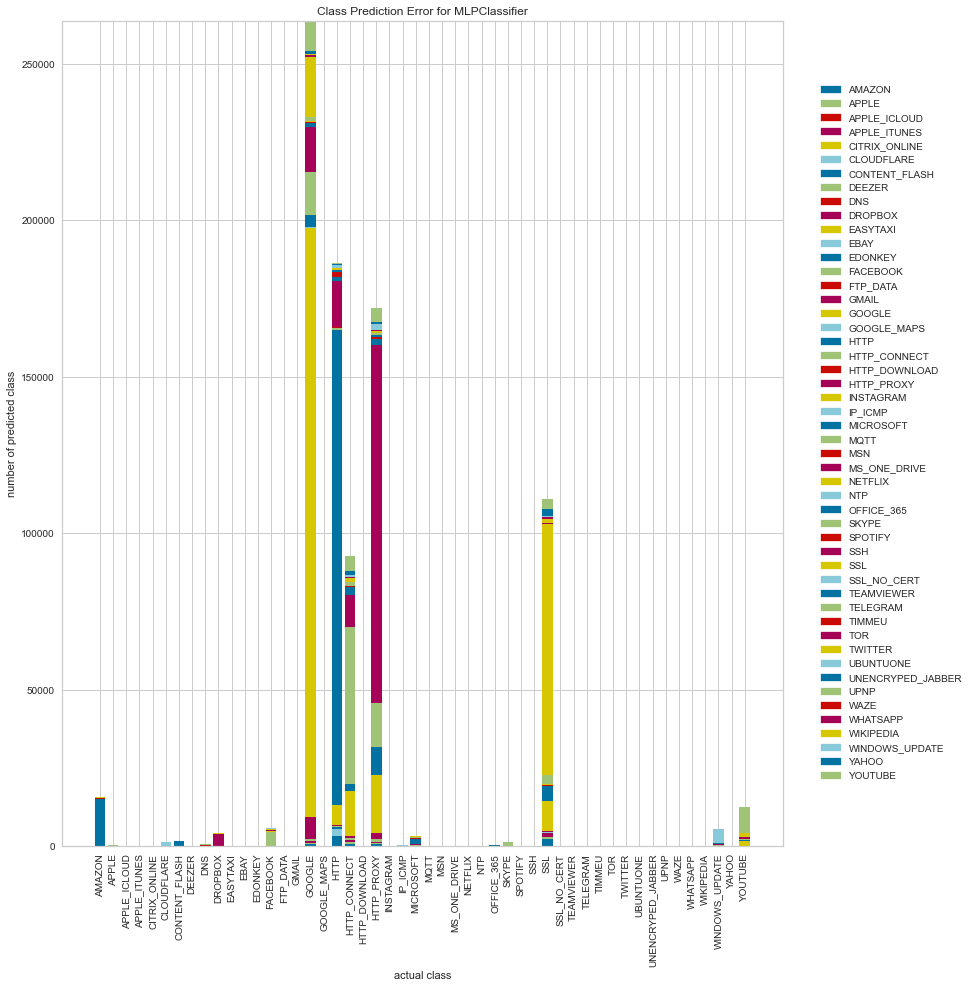

<AxesSubplot:title={'center':'Class Prediction Error for MLPClassifier'}, xlabel='actual class', ylabel='number of predicted class'>

In [37]:
visualizer = classifier.ClassPredictionError(clf, classes=list(encoder),
                                             is_fitted=True, size=(1100, 1000))
visualizer.fit(rescaled_X_train, y_train)
visualizer.score(rescaled_X_test, y_test)
visualizer.show()

In [38]:
100*((y_test == y_pred).sum())/len(y_pred)

70.31158366403191